# Hasnain Shaukat
# 20020213
### This Notebook is supplementary material to the Research Paper and Reflective Essay

# Loading Google Drive:

In [ ]:
# Access To Google Drive Will Be Required Where Data & Notebook is Stored: 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Project/Hasnain_Shaukat_Project')

Mounted at /content/gdrive


# Importing All The Relevant Libraries:

In [ ]:
# All The Libraries Required Are Pre-Installed in Google Colab:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# GPU Allocation Check:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu

Using device: cpu


# Loading DataSet From Google Drive:

In [ ]:
# Data Loading From Google Drive
train_dataset_path= '/content/gdrive/MyDrive/Project/Hasnain_Shaukat_Project/Train' # Add The Path of Training Folder
test_dataset_path='/content/gdrive/MyDrive/Project/Hasnain_Shaukat_Project/Test' # Add The Path of Testing Folder

# Image Pre-Processing:

In [ ]:
# Image Transformation:
#Defining Transforms For Training Dataset:
train_transforms= transforms.Compose([
    transforms.Resize((100,100)), # Resizing All the images to 100x100
    transforms.ToTensor(),
    transforms.Grayscale(1), # Converting all The Coloured Images to Grayscale
    transforms.RandomRotation(15) # Applying random rotation of 15 degrees
])

#Defining Transforms For Testing Dataset:
test_transforms= transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Grayscale(1),
    transforms.RandomRotation(15)
])

In [ ]:
# Loading Folders and Applying Transforms:
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path,transform= train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path,transform= test_transforms)


# Shuffling the Training Dataset and Loading:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)

# Displaying Transformed Images From Training DataSet:

In [ ]:
# Function to Display Images From Dataset:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(30,2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

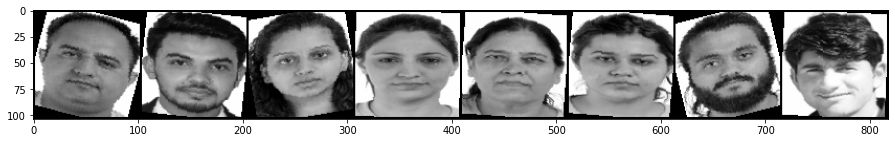

The Values are : Indian Pakistani Indian Indian Indian Indian Indian Pakistani


In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:8]))
classes=["Indian","Pakistani"]
print("The Values are :",' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

# Defining Model:

In [ ]:
# Create a ResNet Block, and ResNet MacroModule:

#Creating The ResNet Block:
class Residual_block(nn.Module):  
    def __init__(self, input_channels, output_channels, use_1x1conv=False, strides=1):
        super(Residual_block, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(output_channels, output_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, output_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
            
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) 
        out = self.bn2(self.conv2(out))
        if self.conv3:
            x = self.conv3(x)
        out = out + x
        return F.relu(out)


# Creating ResNet Macro-Module:
class Resnet_macro_block(nn.Module):
    def __init__(self, input_channels, output_channels, num_residuals, first_block=False):
        super(Resnet_macro_block, self).__init__()
        self.num_residuals = num_residuals
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.add_module('conv{0}'.format(i), 
                                Residual_block(input_channels, output_channels, use_1x1conv=True, strides=2))
            else:
                self.add_module('conv{0}'.format(i), 
                                Residual_block(output_channels, output_channels))
    def forward(self, x):
        out = x
        for i in range(self.num_residuals):
            out = self._modules['conv{0}'.format(i)](out)
        return out 

#Creating the ResNet-18 Structure:
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.stem = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(64), nn.ReLU())
        self.b2 = Resnet_macro_block(64, 64, 2)
        self.b3 = Resnet_macro_block(64, 128, 2)
        self.b4 = Resnet_macro_block(128, 256, 2)
        self.b5 = Resnet_macro_block(256, 512, 2)
        self.last = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), nn.Flatten(), nn.Linear(512, 2))
        
    def forward(self, x):
        out = self.stem(x)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.last(out)
        return out

#Model Name:
model = Resnet18()

# Defining Optimizer & Loss Function:

In [ ]:
# The Loss Function Employed is Cross Entropy Loss:

criterion = nn.CrossEntropyLoss()

# The Optimizer Used is Stochastic Gradient Descent:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.01)

# Training & Testing Stage:

In [ ]:
# Function to Save The Best Testing Accuracy:
def Save_ChkPoint(model,epoch,optimizer,best_accuracy):
  state={"epoch":epoch+1,
         "model":model.state_dict(), 
         "best accuracy": best_accuracy,
         "optimizer":optimizer.state_dict(),
  }
  torch.save(state,"model_best_checkpoint.pth.tar")

#Training:
def Train_NN(model,train_loader,test_loader,criterion,optimizer,n_epochs):
  best_accuracy=0
  
  for epoch in range(n_epochs):
    print("Epoch number %d " % (epoch +1))
    model.train()
    running_loss=0.0
    running_correct=0.0
    total=0

    for data in train_loader:
      images,labels=data
      total+= labels.size(0)
      optimizer.zero_grad()
      outputs=model(images)
      _,predicted=torch.max(outputs.data,1)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
      running_correct+= (labels==predicted).sum().item()
    epoch_loss=running_loss/len(train_loader)
    epoch_acc=100.00*running_correct/total
    print(" In Training dataset. We Got %d out of %d images correctly (%.3f%%). Epoch Loss:%.3f"
          % (running_correct,total,epoch_acc,epoch_loss))
    
    test_dataset_acc=Test_NN(model,test_loader)

    if (test_dataset_acc > best_accuracy):
      best_accuracy=test_dataset_acc
      Save_ChkPoint(model,epoch,optimizer,best_accuracy)


# Testing:
def Test_NN(model,test_loader):
  model.eval()
  prdt_crct=0
  total=0

  with torch.no_grad():
    for data in test_loader:
      images,labels=data
      total+=labels.size(0)
      outputs=model(images)
      _,predicted=torch.max(outputs.data,1)
      prdt_crct+=(predicted==labels).sum().item()
  epoch_acc=100.0* prdt_crct/total
  print(" In Testing dataset. We Got %d out of %d images correctly (%.3f%%)"
        %(prdt_crct,total,epoch_acc))
  return epoch_acc

In [ ]:
# This is When Training begins This will Take Time (Around 1 Hour)
Train_NN(model,train_loader,test_loader,criterion,optimizer,50)

Epoch number 1 
 In Training dataset. We Got 95 out of 200 images correctly (47.500%). Epoch Loss:12.337
 In Testing dataset. We Got 44 out of 88 images correctly (50.000%)
Epoch number 2 
 In Training dataset. We Got 90 out of 200 images correctly (45.000%). Epoch Loss:3.184
 In Testing dataset. We Got 44 out of 88 images correctly (50.000%)
Epoch number 3 
 In Training dataset. We Got 95 out of 200 images correctly (47.500%). Epoch Loss:1.880
 In Testing dataset. We Got 45 out of 88 images correctly (51.136%)
Epoch number 4 
 In Training dataset. We Got 100 out of 200 images correctly (50.000%). Epoch Loss:1.289
 In Testing dataset. We Got 44 out of 88 images correctly (50.000%)
Epoch number 5 
 In Training dataset. We Got 106 out of 200 images correctly (53.000%). Epoch Loss:1.318
 In Testing dataset. We Got 52 out of 88 images correctly (59.091%)
Epoch number 6 
 In Training dataset. We Got 99 out of 200 images correctly (49.500%). Epoch Loss:1.399
 In Testing dataset. We Got 44 ou

In [ ]:
# Saving Model of Highest Testing Accuracy:
checkpoint=torch.load("model_best_checkpoint.pth.tar")

print("The Highest Accuracy was Achieved on Epoch No:",checkpoint["epoch"])
print("The Highest Accuracy Achieved was:",checkpoint["best accuracy"])

model.load_state_dict(checkpoint["model"])

torch.save(model,"best_model.pth")

The Highest Accuracy was Achieved on Epoch No: 37
The Highest Accuracy Achieved was: 92.04545454545455


# Checking Testing DataSet & Some Predictions:

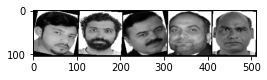

The Ground Truth Values are: Pakistani Indian Pakistani Pakistani Indian
The Predictions Made By Model:  Pakistani Indian Pakistani Pakistani Pakistani


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(4,2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = model(images)
_, predicted = torch.max(outputs, 1)
imshow(torchvision.utils.make_grid(images[:5]))

#printing Ground Truth=labels
classes=["Indian","Pakistani"]
print("The Ground Truth Values are:",' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))
print('The Predictions Made By Model: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(5)))

# Evaluation Metrics:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=90,shuffle=True)
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = model(images)
_, predicted = torch.max(outputs, 1)
cm=confusion_matrix(y_true=labels,y_pred=predicted)

In [ ]:
# Confusion Matrix:
print(cm)

[[39  5]
 [ 3 41]]


In [ ]:
# The Evaluation Metrics Used are Accuracy, Precision & Recall:
print(classification_report(labels,predicted))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        44
           1       0.89      0.93      0.91        44

    accuracy                           0.91        88
   macro avg       0.91      0.91      0.91        88
weighted avg       0.91      0.91      0.91        88



# References:

#### [1] ResNet Model Lecture and Lab Notes: ECS659P - NEURAL NETWORKS AND DEEP LEARNING (2021/22)

[2] Pytorch Tutorial Series:(2022)
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
 

[3] He, K. et al. (2016) ‘Deep Residual Learning for Image Recognition’, in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Las Vegas, NV, USA: IEEE, pp. 770–778. Available at: https://doi.org/10.1109/CVPR.2016.90.
